In [262]:
library(nichenetr)
library(tidyverse)
library(Seurat)
library(cowplot)
library(ggpubr)

In [263]:
ligand_target_matrix = readRDS(url("https://zenodo.org/record/3260758/files/ligand_target_matrix.rds"))
ligand_target_matrix[1:5,1:5]

,CXCL1,CXCL2,CXCL3,CXCL5,PPBP
A1BG,3.534343e-04,4.041324e-04,3.729920e-04,3.080640e-04,2.628388e-04
A1BG-AS1,1.650894e-04,1.509213e-04,1.583594e-04,1.317253e-04,1.231819e-04
A1CF,5.787175e-04,4.596295e-04,3.895907e-04,3.293275e-04,3.211944e-04
A2M,6.027058e-04,5.996617e-04,5.164365e-04,4.517236e-04,4.590521e-04
A2M-AS1,8.898724e-05,8.243341e-05,7.484018e-05,4.912514e-05,5.120439e-05


In [264]:
hnscc_expression <- readRDS('~/decidua/10xVisium/file/to_tangram/Epreg_noFilter.rds')

In [265]:
# hnscc_expression <- NormalizeData(hnscc_expression)

In [266]:
expression = t(as.matrix(hnscc_expression@assays$RNA@data))
sample_info = hnscc_expression@meta.data

In [267]:
# CAF_ids = row.names(sample_info[sample_info$new.type %in% c('dS1','dS2','dS3'),])
CAF_ids = row.names(sample_info[sample_info$new.type %in% c('dS2','dS3'),])
# CAF_ids = row.names(sample_info[sample_info$new.type %in% c('dS2'),])
# malignant_ids = row.names(sample_info[sample_info$new.type %in% c('dNKp','dNK1','dNK2','dNK3'),])
malignant_ids = row.names(sample_info[sample_info$new.type %in% c('dNKp','dNK1','dNK2'),])
# malignant_ids = row.names(sample_info[sample_info$new.type %in% c('dNK1'),])
# malignant_ids = row.names(sample_info[sample_info$new.type %in% c('dNK2'),])

In [268]:
expressed_genes_sender = expression[CAF_ids,] %>% apply(2,function(x){10*(2**x - 1)}) %>% apply(2,function(x){log2(mean(x) + 1)}) %>% .[. >= 4] %>% names()
expressed_genes_receiver = expression[malignant_ids,] %>% apply(2,function(x){10*(2**x - 1)}) %>% apply(2,function(x){log2(mean(x) + 1)}) %>% .[. >= 4] %>% names()

In [269]:
length(expressed_genes_sender)

[1] 2666

In [270]:
length(expressed_genes_receiver)

[1] 1182

In [271]:
geneset_oi = as.vector(read.csv('~/decidua/10xVisium/file/new/dnk_genes.with_distance.txt', header = FALSE)$V1)

In [272]:
background_expressed_genes = expressed_genes_receiver %>% .[. %in% rownames(ligand_target_matrix)]
head(background_expressed_genes)

[1] "ISG15"    "TNFRSF18" "TNFRSF4"  "AURKAIP1" "MRPL20"   "RPL22"

In [273]:
lr_network = readRDS(url("https://zenodo.org/record/3260758/files/lr_network.rds"))

In [274]:
ligands = lr_network %>% pull(from) %>% unique()
expressed_ligands = intersect(ligands,expressed_genes_sender)

receptors = lr_network %>% pull(to) %>% unique()
expressed_receptors = intersect(receptors,expressed_genes_receiver)

lr_network_expressed = lr_network %>% filter(from %in% expressed_ligands & to %in% expressed_receptors) 
head(lr_network_expressed)

from,to,source,database
<chr>,<chr>,<chr>,<chr>
CXCL10,CXCR3,kegg_cytokines,kegg
CXCL12,CXCR4,kegg_cytokines,kegg
IL15,IL2RG,kegg_cytokines,kegg
IL15,IL2RB,kegg_cytokines,kegg
ICAM1,ITGB2,kegg_cams,kegg
CD99,CD99,kegg_cams,kegg


In [275]:
background_expressed_genes = expressed_genes_receiver %>% .[. %in% rownames(ligand_target_matrix)]
head(background_expressed_genes)

[1] "ISG15"    "TNFRSF18" "TNFRSF4"  "AURKAIP1" "MRPL20"   "RPL22"

In [276]:
potential_ligands = lr_network_expressed %>% pull(from) %>% unique()
head(potential_ligands)

[1] "CXCL10" "CXCL12" "IL15"   "ICAM1"  "CD99"   "ICAM2"

In [277]:
potential_ligands

[1] "CXCL10"  "CXCL12"  "IL15"    "ICAM1"   "CD99"    "ICAM2"   "JAM2"   
 [8] "VCAM1"   "COL1A1"  "LAMC3"   "FN1"     "SPP1"    "VTN"     "CCL5"   
[15] "ADAM9"   "C3"      "CCL21"   "COL18A1" "COL4A1"  "HLA-C"   "HLA-E"  
[22] "LAMB1"   "ARF1"    "CALR"    "CXCL13"  "PLAU"    "ANXA1"   "APP"    
[29] "CXCL2"   "CXCL3"   "GAL"     "RTN4"    "GSTP1"   "RPS19"   "CALM1"  
[36] "PTHLH"   "ADM"     "SST"     "NPW"     "THBS1"   "MDK"     "ITGB1"  
[43] "IGF1"    "MIF"     "FBN1"    "PTN"     "HMGB1"   "CXCL14"  "TRH"    
[50] "XCL1"    "PROK1"   "NAMPT"   "HMGB2"   "AIMP1"   "WNT5A"   "XCL2"   
[57] "LGALS3"  "HLA-DRA" "PRL"

In [278]:
ligand_activities = predict_ligand_activities(geneset = geneset_oi, background_expressed_genes = background_expressed_genes, ligand_target_matrix = ligand_target_matrix, potential_ligands = potential_ligands)

In [279]:
ligand_activities %>% arrange(-pearson) 

test_ligand,auroc,aupr,aupr_corrected,pearson
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
IL15,0.5832686,0.2173150,5.023477e-02,0.0955057084
JAM2,0.5381881,0.1837698,1.668962e-02,0.0390749947
COL18A1,0.5258143,0.1766922,9.611942e-03,0.0188576951
COL1A1,0.5240790,0.1742592,7.178940e-03,0.0151952961
HLA-E,0.5026547,0.1739370,6.856735e-03,0.0130607016
THBS1,0.5218717,0.1767411,9.660854e-03,0.0117358813
COL4A1,0.5144140,0.1733098,6.229534e-03,0.0091625483
IGF1,0.4767223,0.1670371,-4.315154e-05,0.0088637925
MIF,0.4911166,0.1690526,1.972403e-03,0.0053911332


In [280]:
best_upstream_ligands = ligand_activities %>% top_n(20, pearson) %>% arrange(-pearson) %>% pull(test_ligand)
head(best_upstream_ligands)

[1] "IL15"    "JAM2"    "COL18A1" "COL1A1"  "HLA-E"   "THBS1"

In [ ]:
row.names(ligand_activities)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



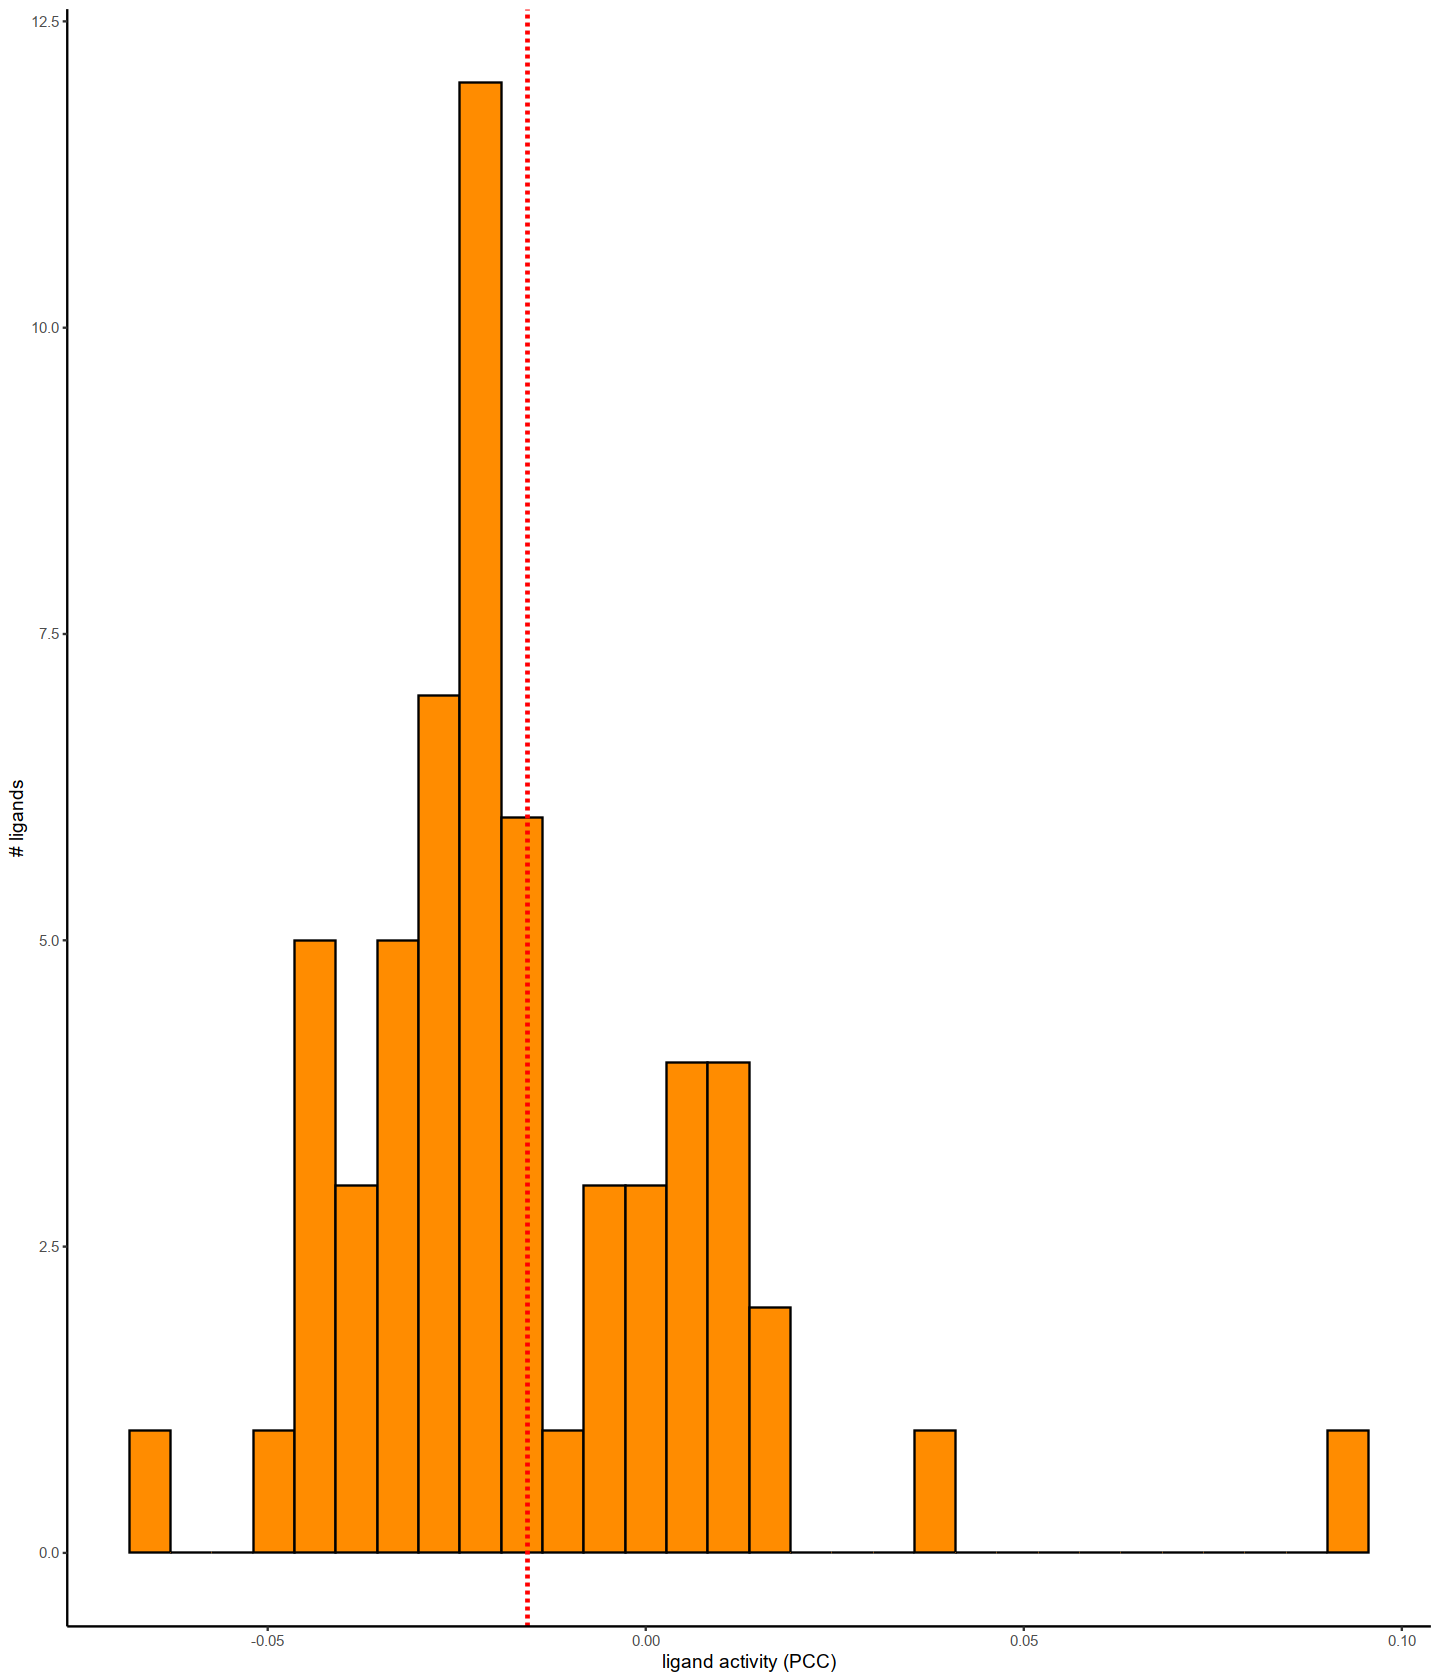

In [282]:
# show histogram of ligand activity scores
p_hist_lig_activity = ggplot(ligand_activities, aes(x=pearson)) + 
  geom_histogram(color="black", fill="darkorange")  + 
  # geom_density(alpha=.1, fill="orange") +
  geom_vline(aes(xintercept=min(ligand_activities %>% top_n(20, pearson) %>% pull(pearson))), color="red", linetype="dashed", size=1) + 
  labs(x="ligand activity (PCC)", y = "# ligands") +
  theme_classic()
p_hist_lig_activity

In [283]:
active_ligand_target_links_df = best_upstream_ligands %>% lapply(get_weighted_ligand_target_links,geneset = geneset_oi, ligand_target_matrix = ligand_target_matrix, n = 250) %>% bind_rows()

nrow(active_ligand_target_links_df)
## [1] 143
head(active_ligand_target_links_df)

[1] 161

ligand,target,weight
<chr>,<chr>,<dbl>
IL15,CLEC2B,0.004342549
IL15,GZMB,0.004534628
IL15,KLRK1,0.009094287
IL15,PGK1,0.004580406
IL15,PIM2,0.004277290
IL15,PRF1,0.004258016


In [284]:
active_ligand_target_links = prepare_ligand_target_visualization(ligand_target_df = active_ligand_target_links_df, ligand_target_matrix = ligand_target_matrix, cutoff = 0.25)

nrow(active_ligand_target_links_df)
## [1] 143
head(active_ligand_target_links_df)

[1] 161

ligand,target,weight
<chr>,<chr>,<dbl>
IL15,CLEC2B,0.004342549
IL15,GZMB,0.004534628
IL15,KLRK1,0.009094287
IL15,PGK1,0.004580406
IL15,PIM2,0.004277290
IL15,PRF1,0.004258016


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



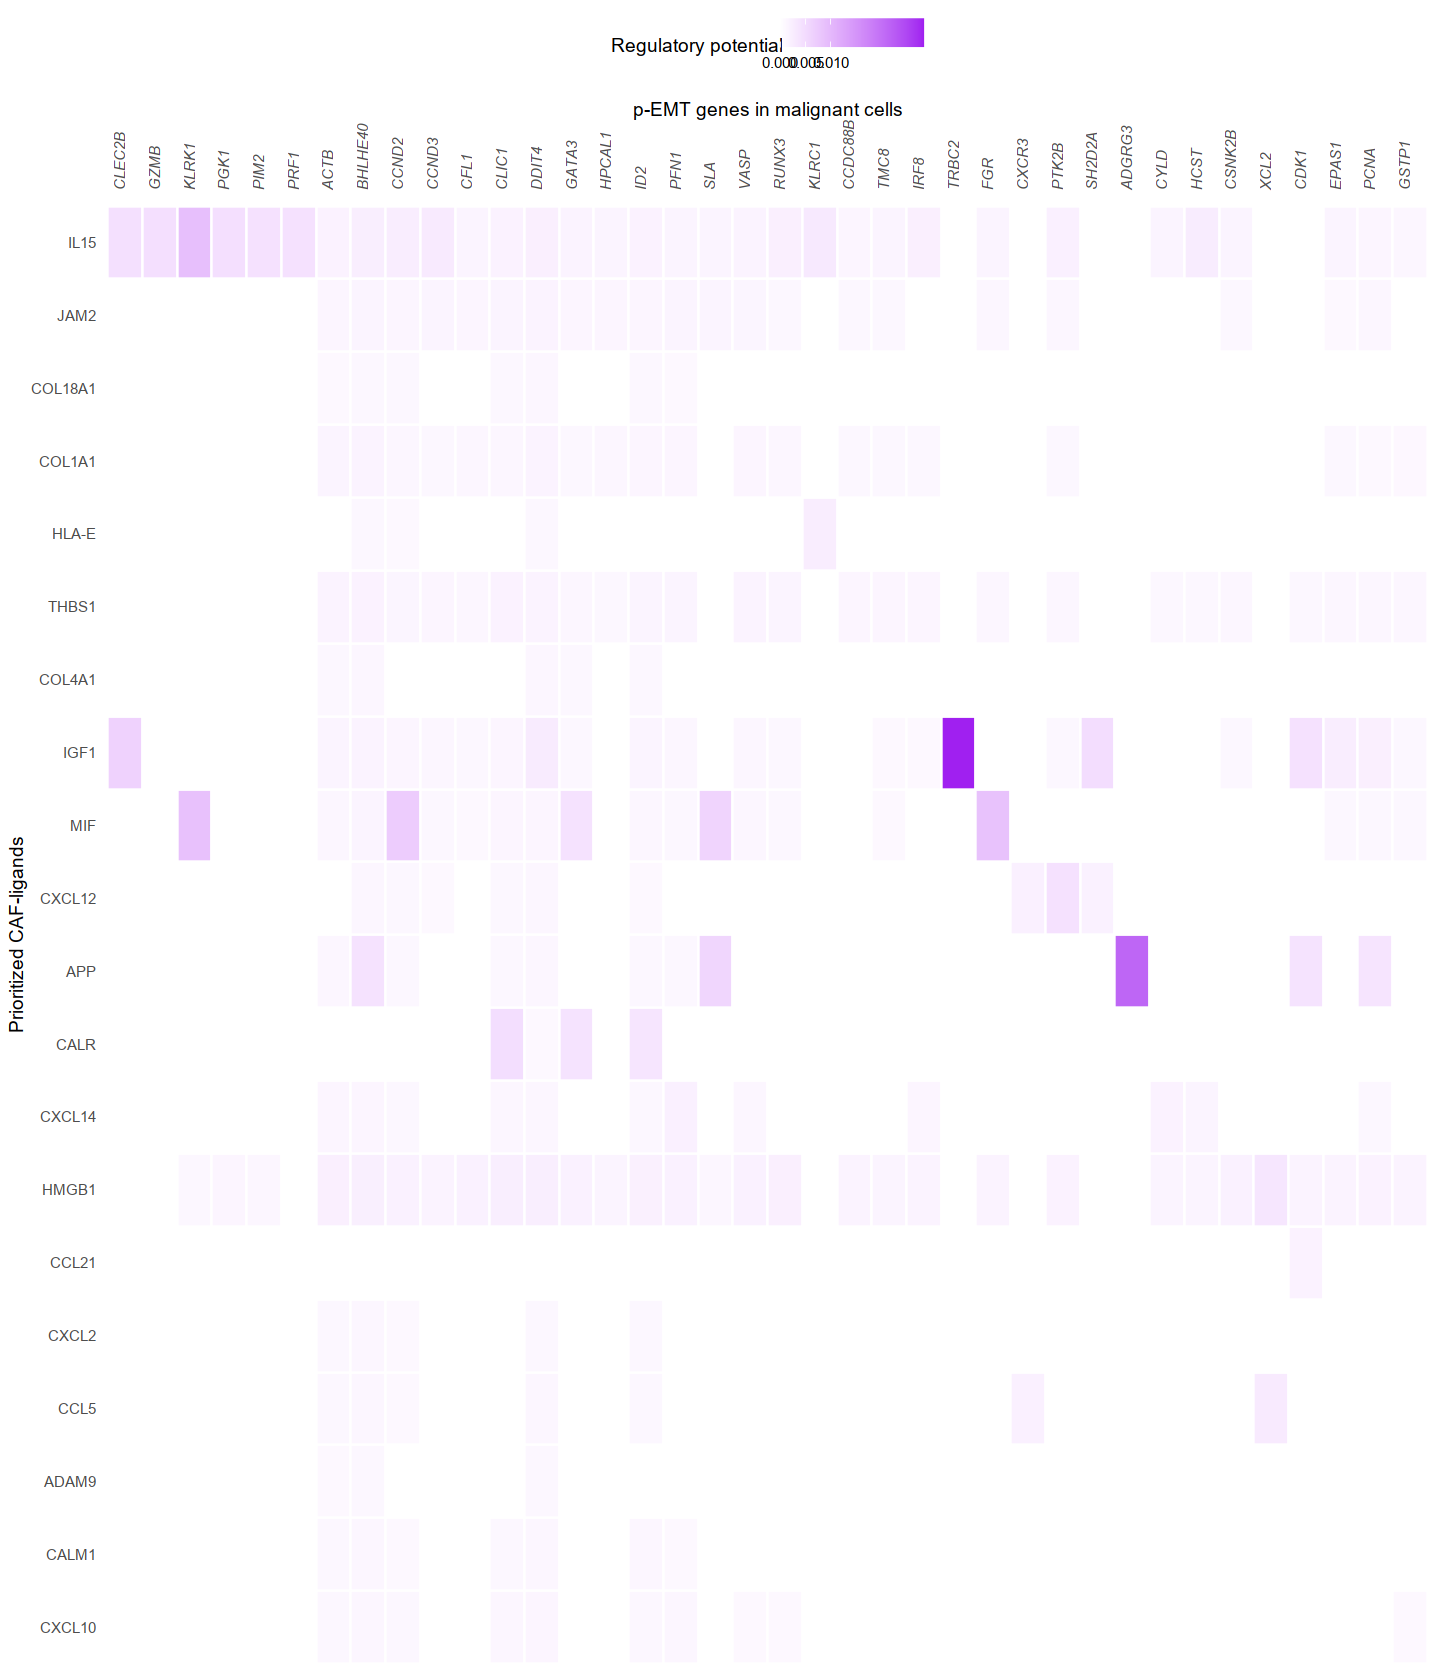

In [285]:
order_ligands = intersect(best_upstream_ligands, colnames(active_ligand_target_links)) %>% rev()
order_targets = active_ligand_target_links_df$target %>% unique()
vis_ligand_target = active_ligand_target_links[order_targets,order_ligands] %>% t()

p_ligand_target_network = vis_ligand_target %>% make_heatmap_ggplot("Prioritized CAF-ligands","p-EMT genes in malignant cells", color = "purple",legend_position = "top", x_axis_position = "top",legend_title = "Regulatory potential") + scale_fill_gradient2(low = "whitesmoke",  high = "purple", breaks = c(0,0.005,0.01)) + theme(axis.text.x = element_text(face = "italic"))

p_ligand_target_network

In [286]:
ligand_pearson_matrix = ligand_activities %>% select(pearson) %>% as.matrix() %>% magrittr::set_rownames(ligand_activities$test_ligand)

vis_ligand_pearson = ligand_pearson_matrix[order_ligands, ] %>% as.matrix(ncol = 1) %>% magrittr::set_colnames("Pearson")

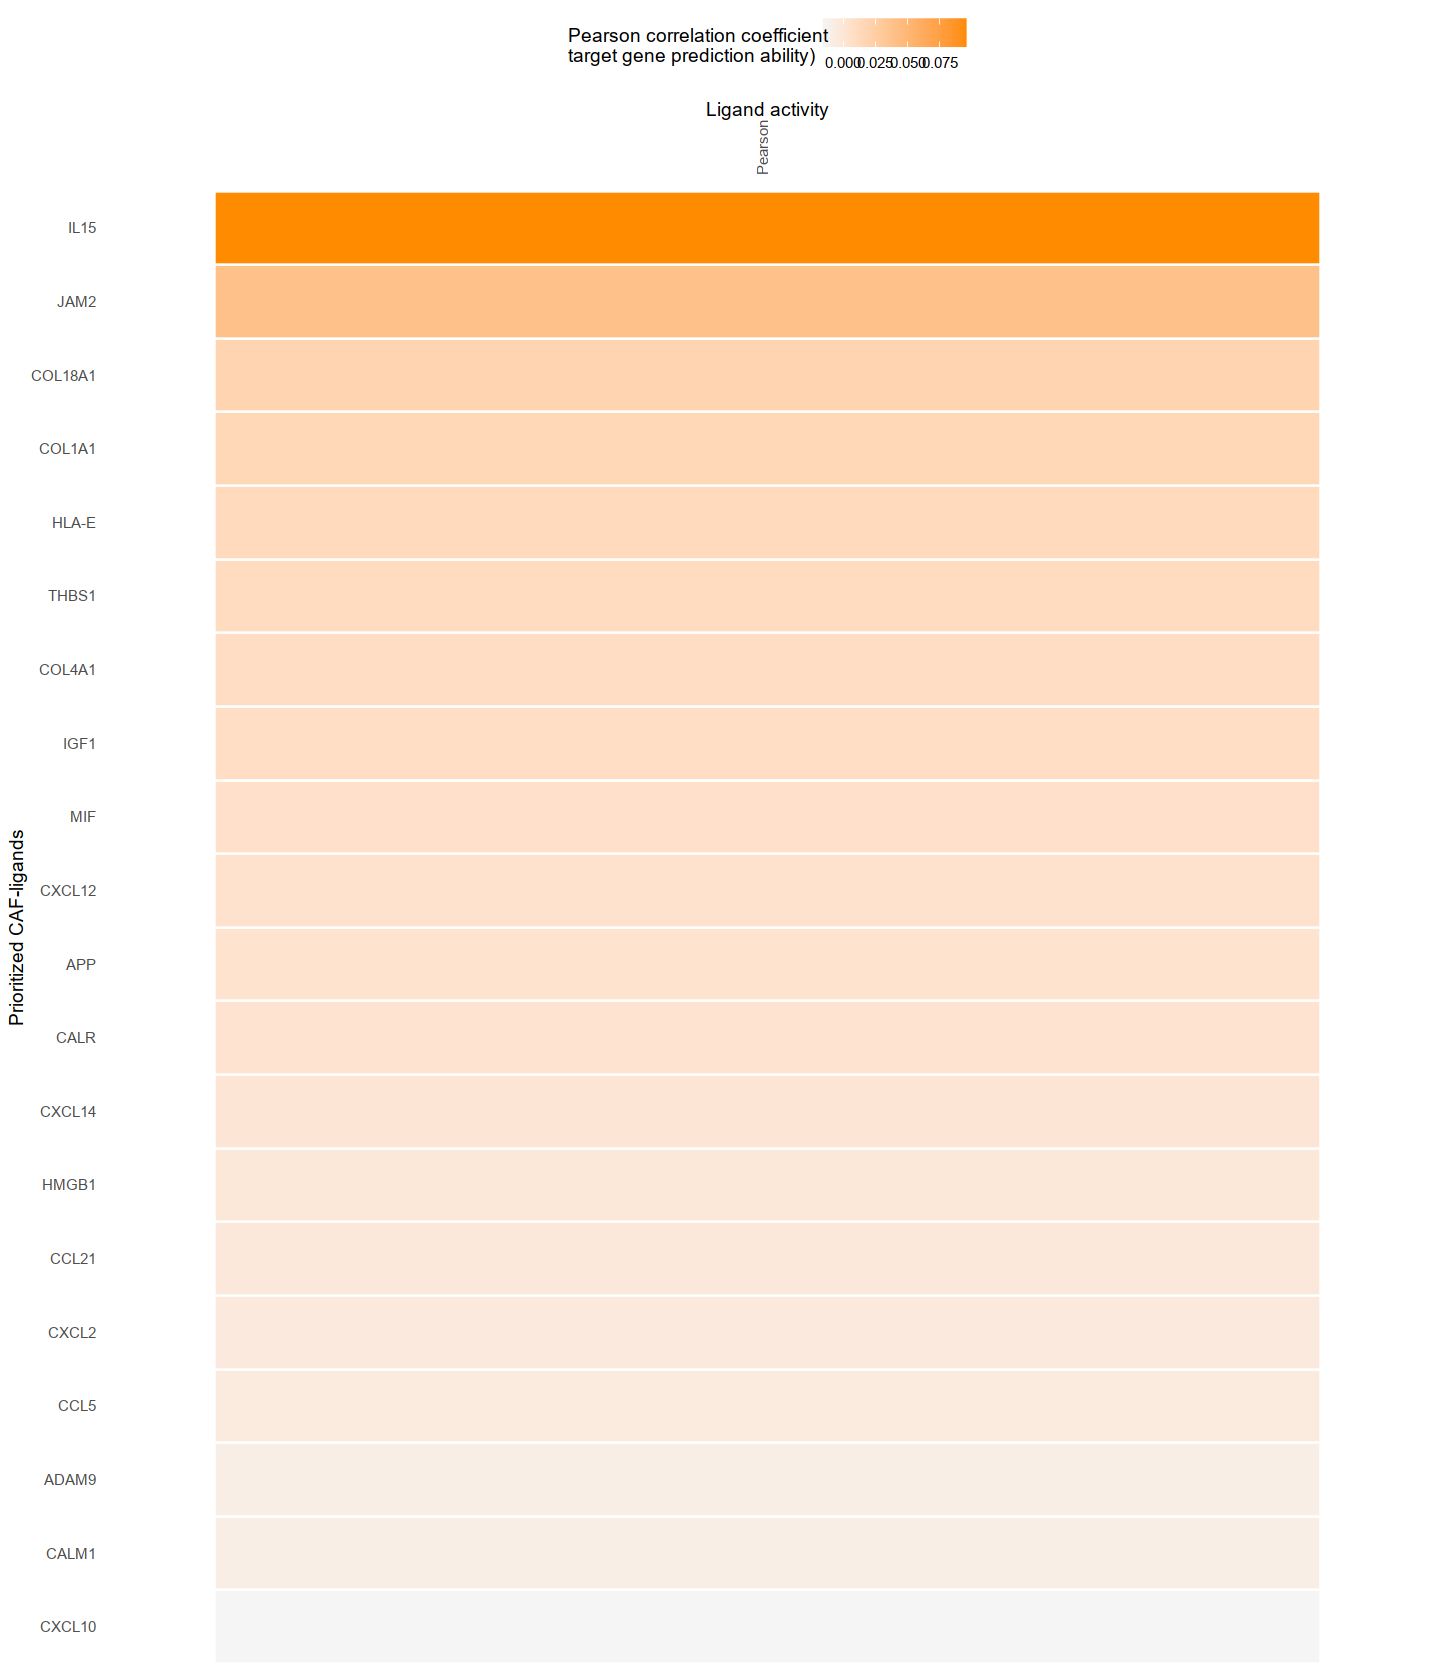

In [287]:
p_ligand_pearson = vis_ligand_pearson %>% make_heatmap_ggplot("Prioritized CAF-ligands","Ligand activity", color = "darkorange",legend_position = "top", x_axis_position = "top", legend_title = "Pearson correlation coefficient\ntarget gene prediction ability)")
p_ligand_pearson

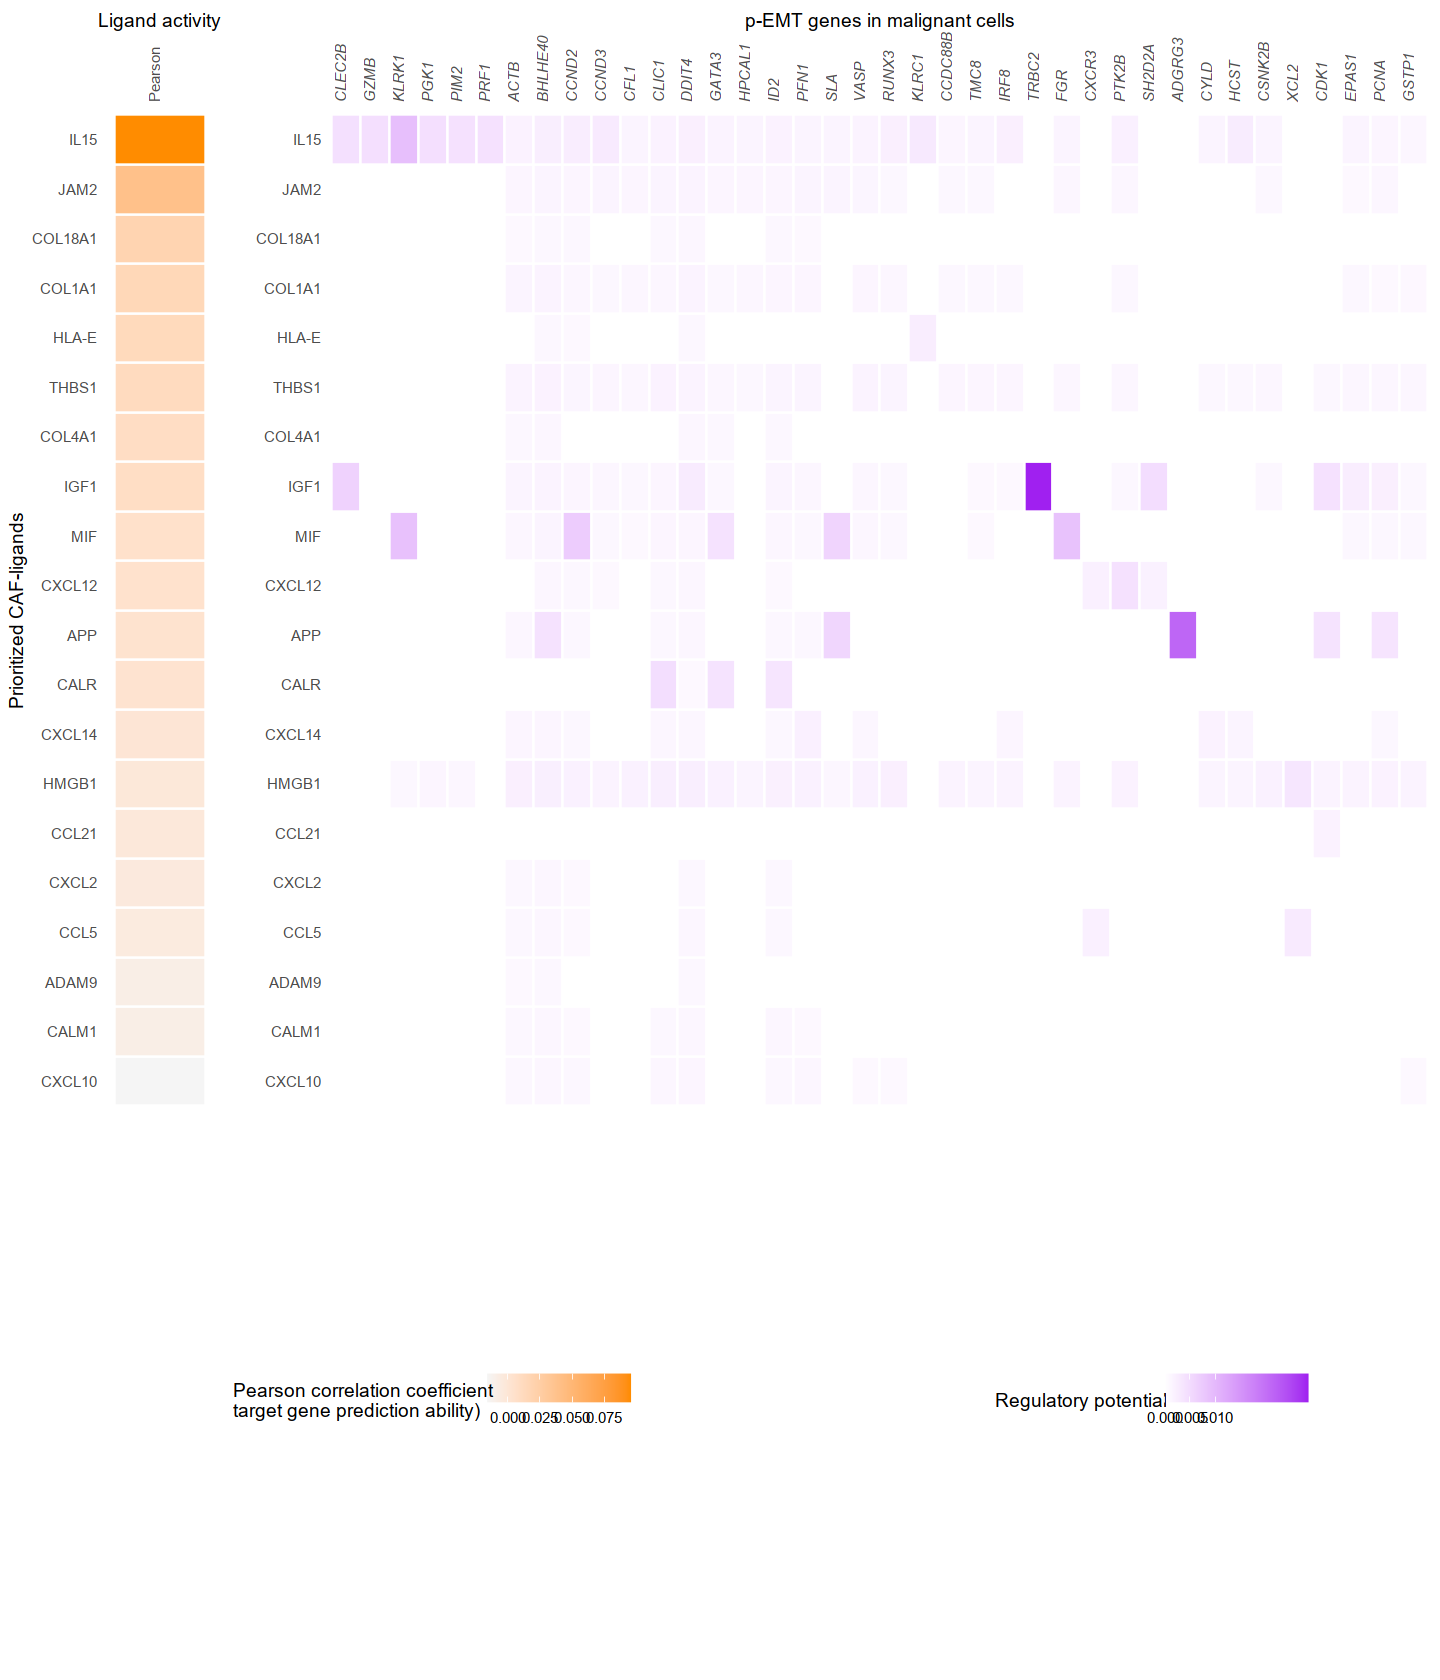

In [288]:
options(repr.plot.width=12, repr.plot.height=14)
figures_without_legend = cowplot::plot_grid(
  p_ligand_pearson + theme(legend.position = "none", axis.ticks = element_blank()) + theme(axis.title.x = element_text()),
  p_ligand_target_network + theme(legend.position = "none", axis.ticks = element_blank()) + ylab(""),
  align = "hv",
  nrow = 1,
  rel_widths = c(ncol(vis_ligand_pearson)+6, ncol(vis_ligand_target)))

legends = cowplot::plot_grid(
    ggpubr::as_ggplot(ggpubr::get_legend(p_ligand_pearson)),
    ggpubr::as_ggplot(ggpubr::get_legend(p_ligand_target_network)),
    nrow = 1,
    align = "h", rel_widths = c(1.5, 1))

combined_plot = cowplot::plot_grid(figures_without_legend, legends, rel_heights = c(10,5), nrow = 2, align = "hv")
combined_plot